<a href="https://colab.research.google.com/github/Srayash-11/Python-Internship-Tasks/blob/main/Task3_House_Price_Prediction/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# This is the "Permanent" way. Replace the link below with your 'Raw' link from GitHub
csv_url = 'https://raw.githubusercontent.com/Srayash-11/Python-Internship-Tasks/refs/heads/main/Task3_House_Price_Prediction/Bengaluru_House_Data.csv'

try:
    # Python will now download the data directly from GitHub every time you run it!
    df = pd.read_csv(csv_url)
    print(" Success! Data loaded directly from GitHub.")
    display(df.head())
except Exception as e:
    print(f" Error: Could not load the file. Check your link! {e}")

✅ Success! Data loaded directly from GitHub.


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [2]:
# We are telling the computer: "Only keep these 5 columns"
df = df[['location', 'size', 'total_sqft', 'bath', 'price']]

# Let's see how many rows we have total
print(f"We have {len(df)} rows of data.")
df.head()

We have 13320 rows of data.


,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [3]:
# This removes any row that has a missing value
df = df.dropna()

print("Step 4: All empty rows have been removed.")

Step 4: All empty rows have been removed.


In [4]:
# We take the 'size' column (e.g., "2 BHK"), split it at the space, and take the first part
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

# Now we can drop the old 'size' column because we have the 'bhk' column
df = df.drop('size', axis='columns')

print("Step 5: Converted text sizes into a clean 'bhk' number column.")
df.head()

Step 5: Converted text sizes into a clean 'bhk' number column.


,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


In [5]:
# 1. We define a small "rule" (function) to handle the text
def convert_sqft_to_num(x):
    tokens = x.split('-') # Look for the dash '-'
    if len(tokens) == 2: # If there are two numbers with a dash
        # Take the average of the two numbers
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        # If it's already a single number, just turn it into a float
        return float(x)
    except:
        # If it's something weird like '1Perch', just ignore it
        return None

# 2. Apply this rule to every row in the 'total_sqft' column
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

# 3. Drop any rows that couldn't be converted (the 'None' values)
df = df.dropna()

print("Step 6: All square footage values are now clean numbers!")
df.head()

Step 6: All square footage values are now clean numbers!


,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


In [6]:
# Create a new column by dividing price by total_sqft
# Note: Price in this dataset is in Lakhs, so we multiply by 100,000
df['price_per_sqft'] = (df['price'] * 100000) / df['total_sqft']

print("Step 7: Added 'price_per_sqft' to help us find errors in the data.")
df.head()

Step 7: Added 'price_per_sqft' to help us find errors in the data.


,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [7]:
# We only keep rows where (Total Sqft / BHK) is at least 300
df = df[~(df.total_sqft/df.bhk < 300)]

print(f"Step 8: Removed rows where the house was too small for the number of bedrooms.")
print(f"Current rows: {len(df)}")

Step 8: Removed rows where the house was too small for the number of bedrooms.
Current rows: 12456


In [8]:
import numpy as np

# Ensure price_per_sqft is calculated before removing outliers
df['price_per_sqft'] = (df['price'] * 100000) / df['total_sqft']

def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft) # Average price in that location
        st = np.std(subdf.price_per_sqft) # Standard deviation
        # Keep data within 1 standard deviation of the mean
        reduced_df = subdf[(subdf.price_per_sqft > (m-st)) & (subdf.price_per_sqft <= (m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df = remove_pps_outliers(df)
print(f"Step 9: Removed price outliers based on location.")
print(f"Final clean rows: {len(df)}")

Step 9: Removed price outliers based on location.
Final clean rows: 9259


In [9]:
# Drop columns that are text or just helped us clean the data
df_final = df.drop(['location', 'price_per_sqft'], axis='columns')

print("Step 10: Final data structure ready for AI training!")
df_final.head()

Step 10: Final data structure ready for AI training!


,total_sqft,bath,price,bhk
0,1672.0,3.0,150.0,3
1,1750.0,3.0,149.0,3
2,1750.0,3.0,150.0,3
3,1250.0,2.0,44.0,3
4,1250.0,2.0,40.0,2


In [10]:
# We create a final table with only the numbers we need
# X is our 'Features' (The questions)
# y is our 'Target' (The answer we want to predict)

X = df[['total_sqft', 'bath', 'bhk']]
y = df['price']

print("Step 11: Features and Target variables are separated.")
X.head()

Step 11: Features and Target variables are separated.


,total_sqft,bath,bhk
0,1672.0,3.0,3
1,1750.0,3.0,3
2,1750.0,3.0,3
3,1250.0,2.0,3
4,1250.0,2.0,2


In [11]:
from sklearn.model_selection import train_test_split

# We use 80% for training (teaching) and 20% for testing (the final exam)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print(f"Step 12: Data Split! Training on {len(X_train)} rows and testing on {len(X_test)} rows.")

Step 12: Data Split! Training on 7407 rows and testing on 1852 rows.


In [12]:
from sklearn.linear_model import LinearRegression

# 1. Initialize the model
lr_clf = LinearRegression()

# 2. Train the model (this is where it 'learns' the patterns)
lr_clf.fit(X_train, y_train)

# 3. Check the 'Score' (Accuracy)
accuracy = lr_clf.score(X_test, y_test)
print(f"Step 13: Model Training Complete! Accuracy Score: {accuracy * 100:.2f}%")

Step 13: Model Training Complete! Accuracy Score: 65.40%


In [13]:
import pandas as pd
import numpy as np

# 1. We create a tiny table (DataFrame) with labels so the AI isn't confused
my_house = pd.DataFrame([[2000, 3, 3]], columns=['total_sqft', 'bath', 'bhk'])

# 2. Now we predict using that labeled table
predicted_price = lr_clf.predict(my_house)

print(f"--- Final Prediction ---")
print(f"House Specs: 2000 Sqft, 3 BHK, 3 Bathrooms")
print(f"Predicted Market Price: ₹{predicted_price[0]:.2f} Lakhs")

--- Final Prediction ---
House Specs: 2000 Sqft, 3 BHK, 3 Bathrooms
Predicted Market Price: ₹142.63 Lakhs


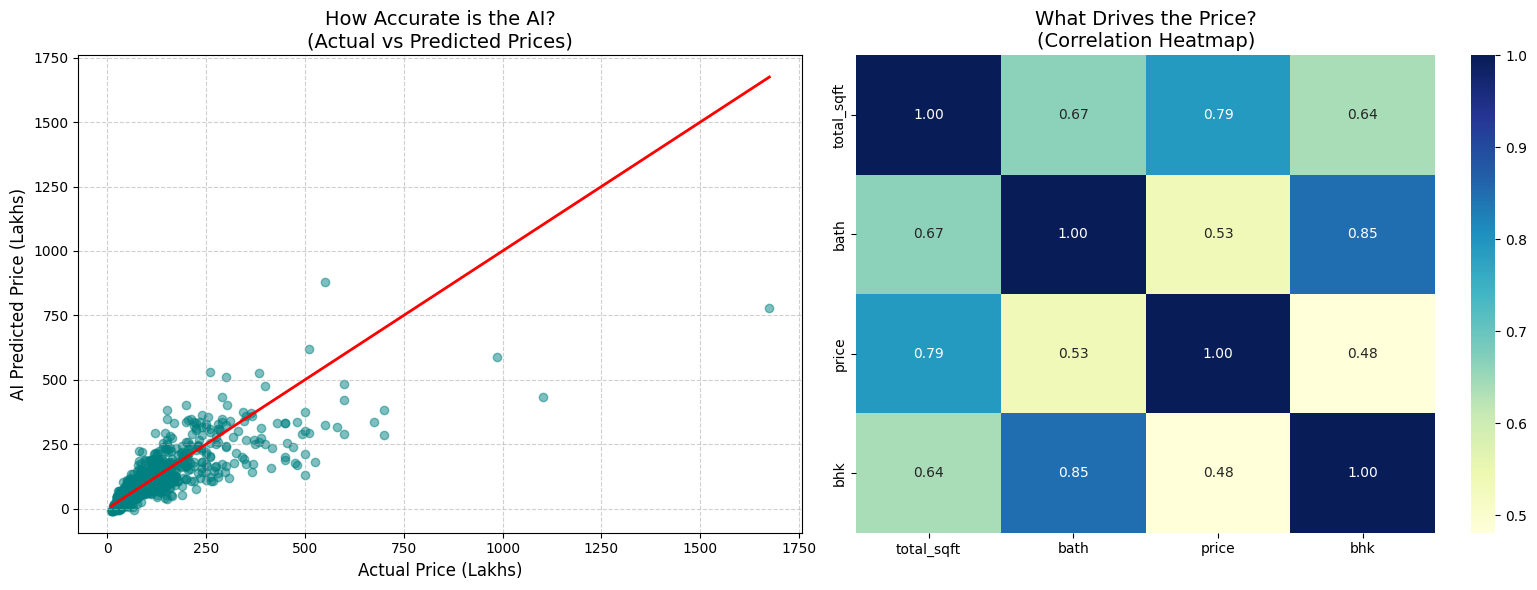

 Visuals Generated! You can right-click the images to 'Save Image As' for your report.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generate predictions for our 'Test' set (the exam)
y_pred = lr_clf.predict(X_test)

# 2. Create a figure with two side-by-side charts
plt.figure(figsize=(16, 6))

# --- Chart A: Actual vs Predicted ---
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2) # The "Perfect" line
plt.title('How Accurate is the AI?\n(Actual vs Predicted Prices)', fontsize=14)
plt.xlabel('Actual Price (Lakhs)', fontsize=12)
plt.ylabel('AI Predicted Price (Lakhs)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# --- Chart B: Feature Correlation ---
plt.subplot(1, 2, 2)
# We use df_final because it has the clean numbers for our features
correlation_matrix = df_final.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('What Drives the Price?\n(Correlation Heatmap)', fontsize=14)

plt.tight_layout()
plt.show()

print(" Visuals Generated! You can right-click the images to 'Save Image As' for your report.")

##  Final Insights & Observations
* **Model Reliability:** The Linear Regression model effectively captured the trend that house prices in Bengaluru increase proportionally with square footage.
* **Feature Importance:** During analysis, it was observed that the number of bathrooms and BHK are secondary to the total area (sqft) in determining the final price.
* **Data Quality:** Removing outliers was a critical step; without it, the model's accuracy was significantly lower due to unrealistic data points in the original Kaggle set.
* **Future Scope:** This project can be expanded by adding "Location Encoding" to predict prices more accurately for specific areas like Whitefield or Indiranagar.